In [1]:
from __future__ import print_function

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%reset -f
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# Any results you write to the current directory are saved as output.
import keras
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as sp
from sys import getsizeof
from sklearn.preprocessing import LabelBinarizer
from keras.layers import AveragePooling2D, Input, Flatten

import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
#read the record of ECG data
import scipy.signal as spsig
import pandas as pd

data_pic=np.load('/kaggle/input/breast/breast-dataset.npy',allow_pickle=True)
data_label=np.load('/kaggle/input/breast/breast-annot.npy',allow_pickle=True)
data_file=np.load('/kaggle/input/breast/breast-file.npy',allow_pickle=True)
data_loc=np.load('/kaggle/input/breast/breast-loc.npy',allow_pickle=True)
data_pic=data_pic.reshape(data_pic.shape[0],data_pic.shape[1],data_pic.shape[2],1)
data_list_uv=np.load('/kaggle/input/breast/breas-uv-boundary.npy',allow_pickle=True)

#col_indx=np.random.permutation(range(data_label.shape[0]))
col_indx=np.load('/kaggle/input/randomize/random_index.npy')
the_label=data_label[col_indx]
the_signal=data_pic[col_indx]

lb = LabelBinarizer()
the_labelx=lb.fit_transform(the_label)

Using TensorFlow backend.


import pydicom
from pydicom.data import get_testdata_files

import random
nind=19
plt.clf()
plt.rcParams["figure.figsize"] =[40,32]
filexml=data_file[nind]
filexmn=filexml[0:-4]
filedcm= ! ls /kaggle/input/heist0/INbreast/AllDICOMs/$filexmn*
ds=pydicom.dcmread(filedcm[0])
plt.imshow(ds.pixel_array,cmap=plt.cm.bone)
xa,ya,xb,yb=data_loc[nind]
plt.scatter([xa,xb,xb,xa],[ya,ya,yb,yb],color='black')
print(data_label[nind])

In [2]:
data_pic.shape

(4880, 250, 250, 1)

m
22614431.xml


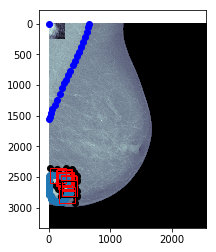

In [3]:
nind=16
import pydicom
from pydicom.data import get_testdata_files
import matplotlib.patches as patches
import random
#jbox=17

import matplotlib.pyplot as plt

plt.clf()
ax = plt.gca()


plt.gca().invert_yaxis()
plt.rcParams["figure.figsize"] =[40,32]
filexml=data_file[nind]
filexmn=filexml[0:-4]
filedcm= ! ls /kaggle/input/heist0/INbreast/AllDICOMs/$filexmn*
ds=pydicom.dcmread(filedcm[0])
#plt.xlim(0,ds.Columns)
#plt.ylim(0,ds.Rows)


plt.imshow(ds.pixel_array,cmap=plt.cm.bone)
plt.imshow(data_pic[15][:,:,0],cmap=plt.cm.bone)
for kotak in range(0,10):
    xa,ya,xb,yb=data_loc[kotak]
    plt.scatter([xa,xb,xb,xa],[ya,ya,yb,yb],color='black')
    rect = patches.Rectangle((xa,ya),(xb-xa),(yb-ya),linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(rect)

for kotak in range(15,16):
    xa,ya,xb,yb=data_loc[kotak]
    plt.scatter([xa,xb,xb,xa],[ya,ya,yb,yb],color='black')
    rect = patches.Rectangle((xa,ya),(xb-xa),(yb-ya),linewidth=1,edgecolor='black',facecolor='none')
    ax.add_patch(rect)
    
ux=data_list_uv[nind][1][:,0]
uy=data_list_uv[nind][1][:,1]
plt.scatter(ux,uy,color='blue')
plt.scatter(data_list_uv[nind][0][:,0],data_list_uv[nind][0][:,1])
print(data_label[nind])
print(filexml)

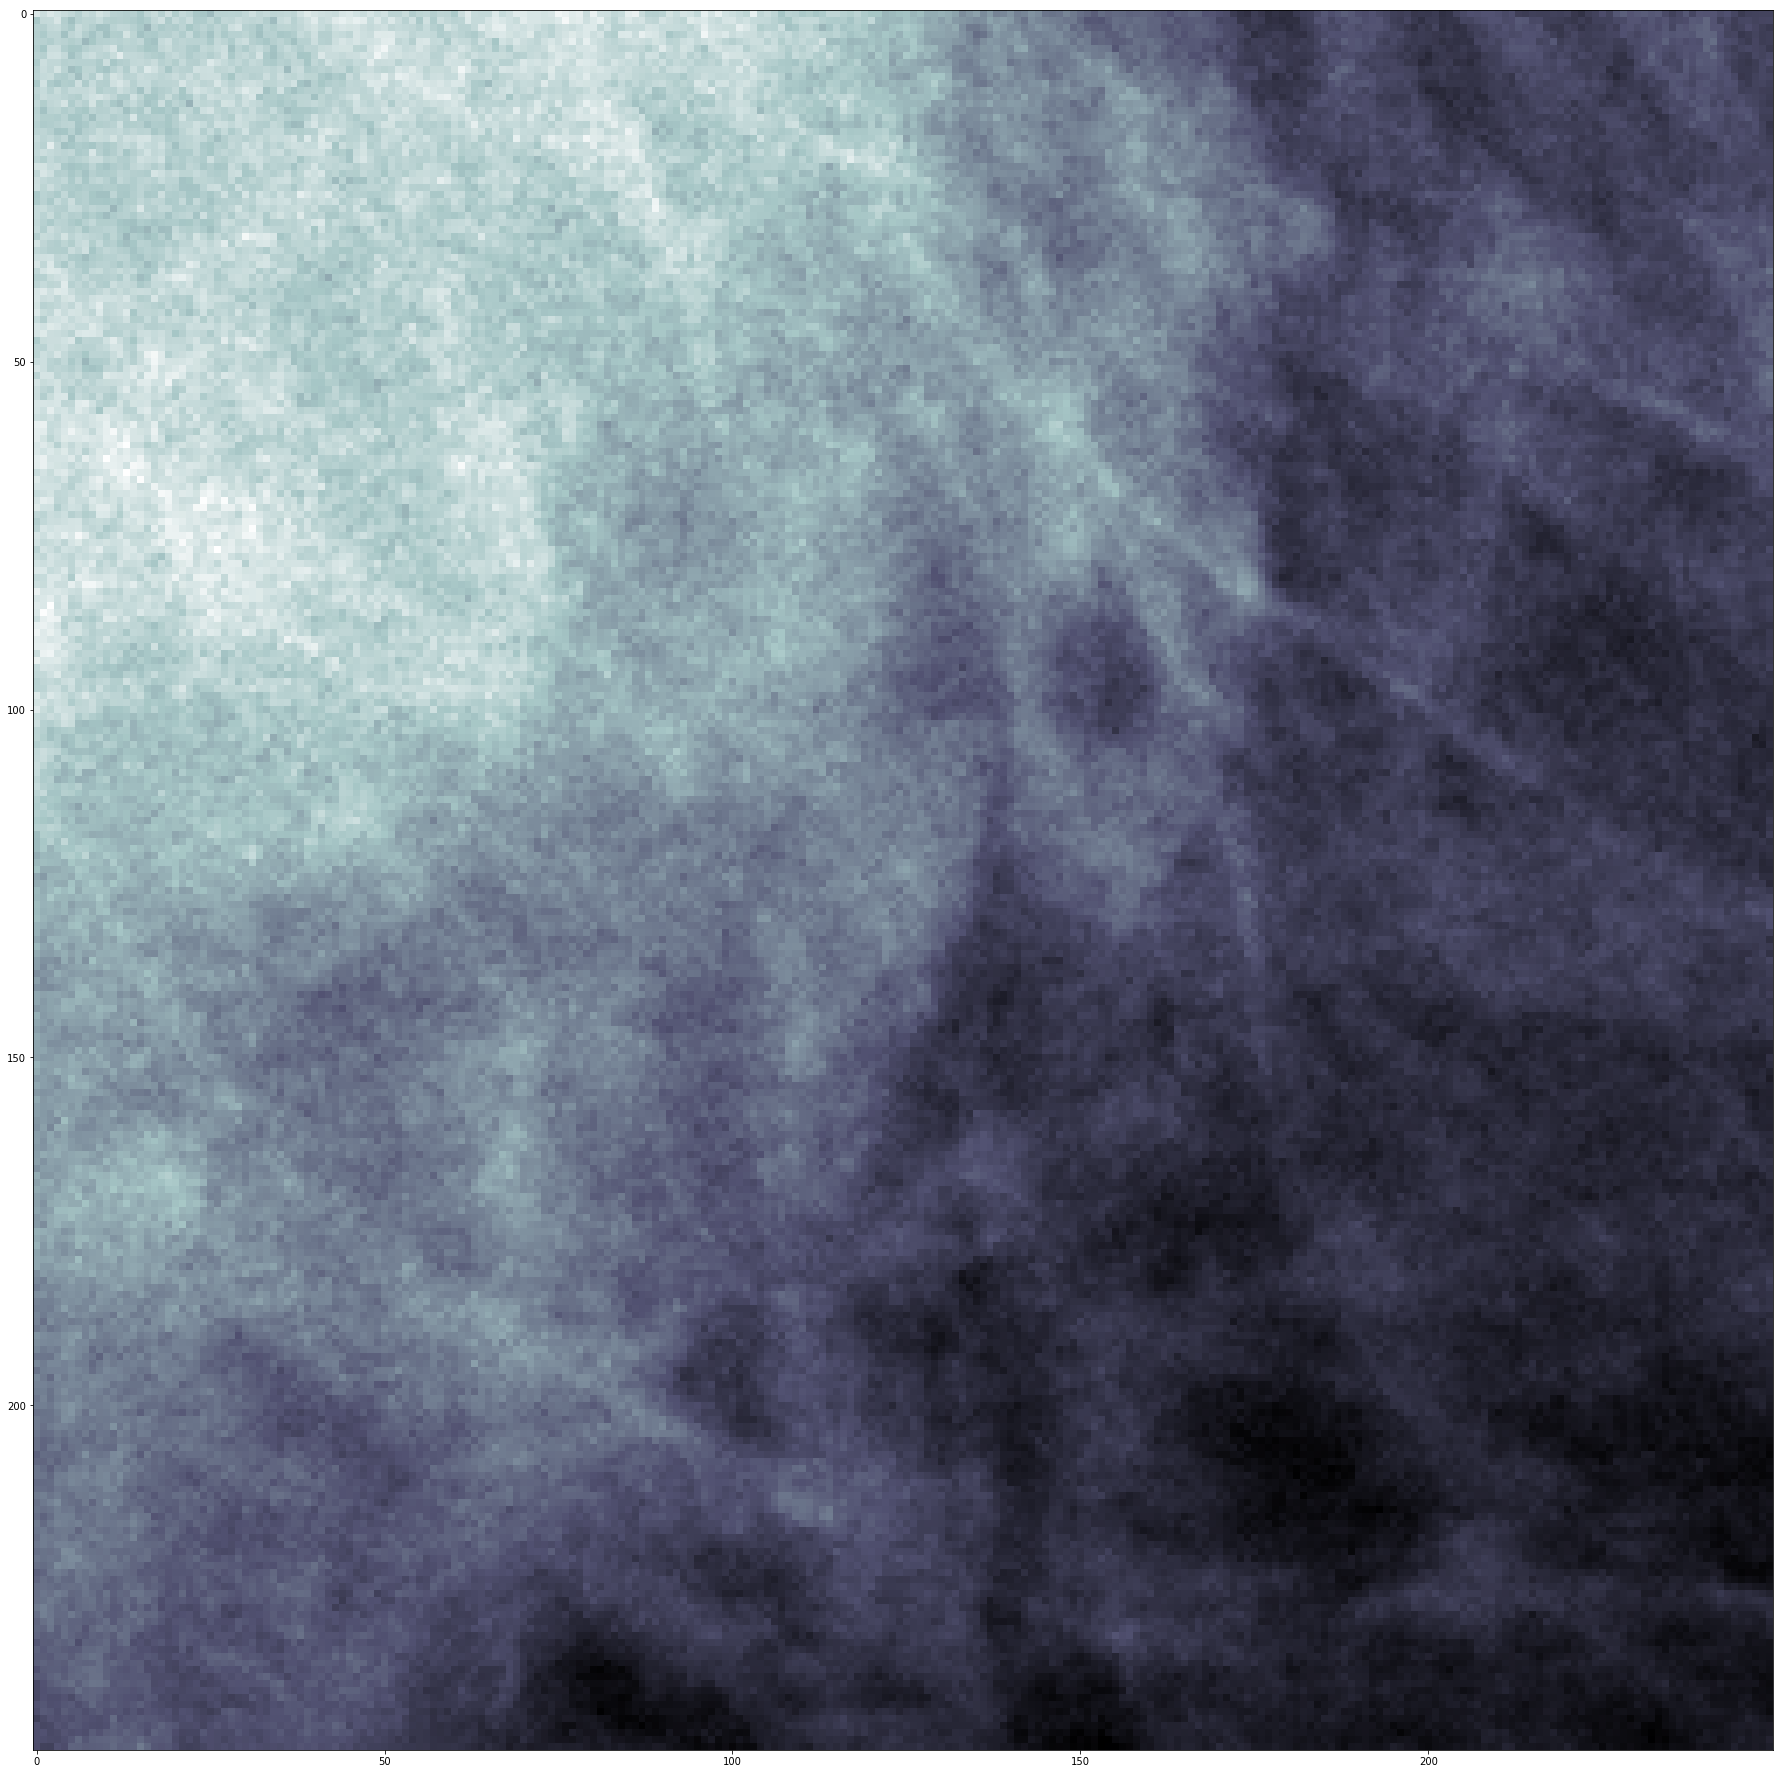

In [4]:
plt.imshow(data_pic[11][:,:,0],cmap=plt.cm.bone)

****plt.plot(the_label2[0:100])

In [5]:
data_pic.shape

(4880, 250, 250, 1)

In [6]:
the_signal.shape

(4880, 250, 250, 1)

(array([1220.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3660.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

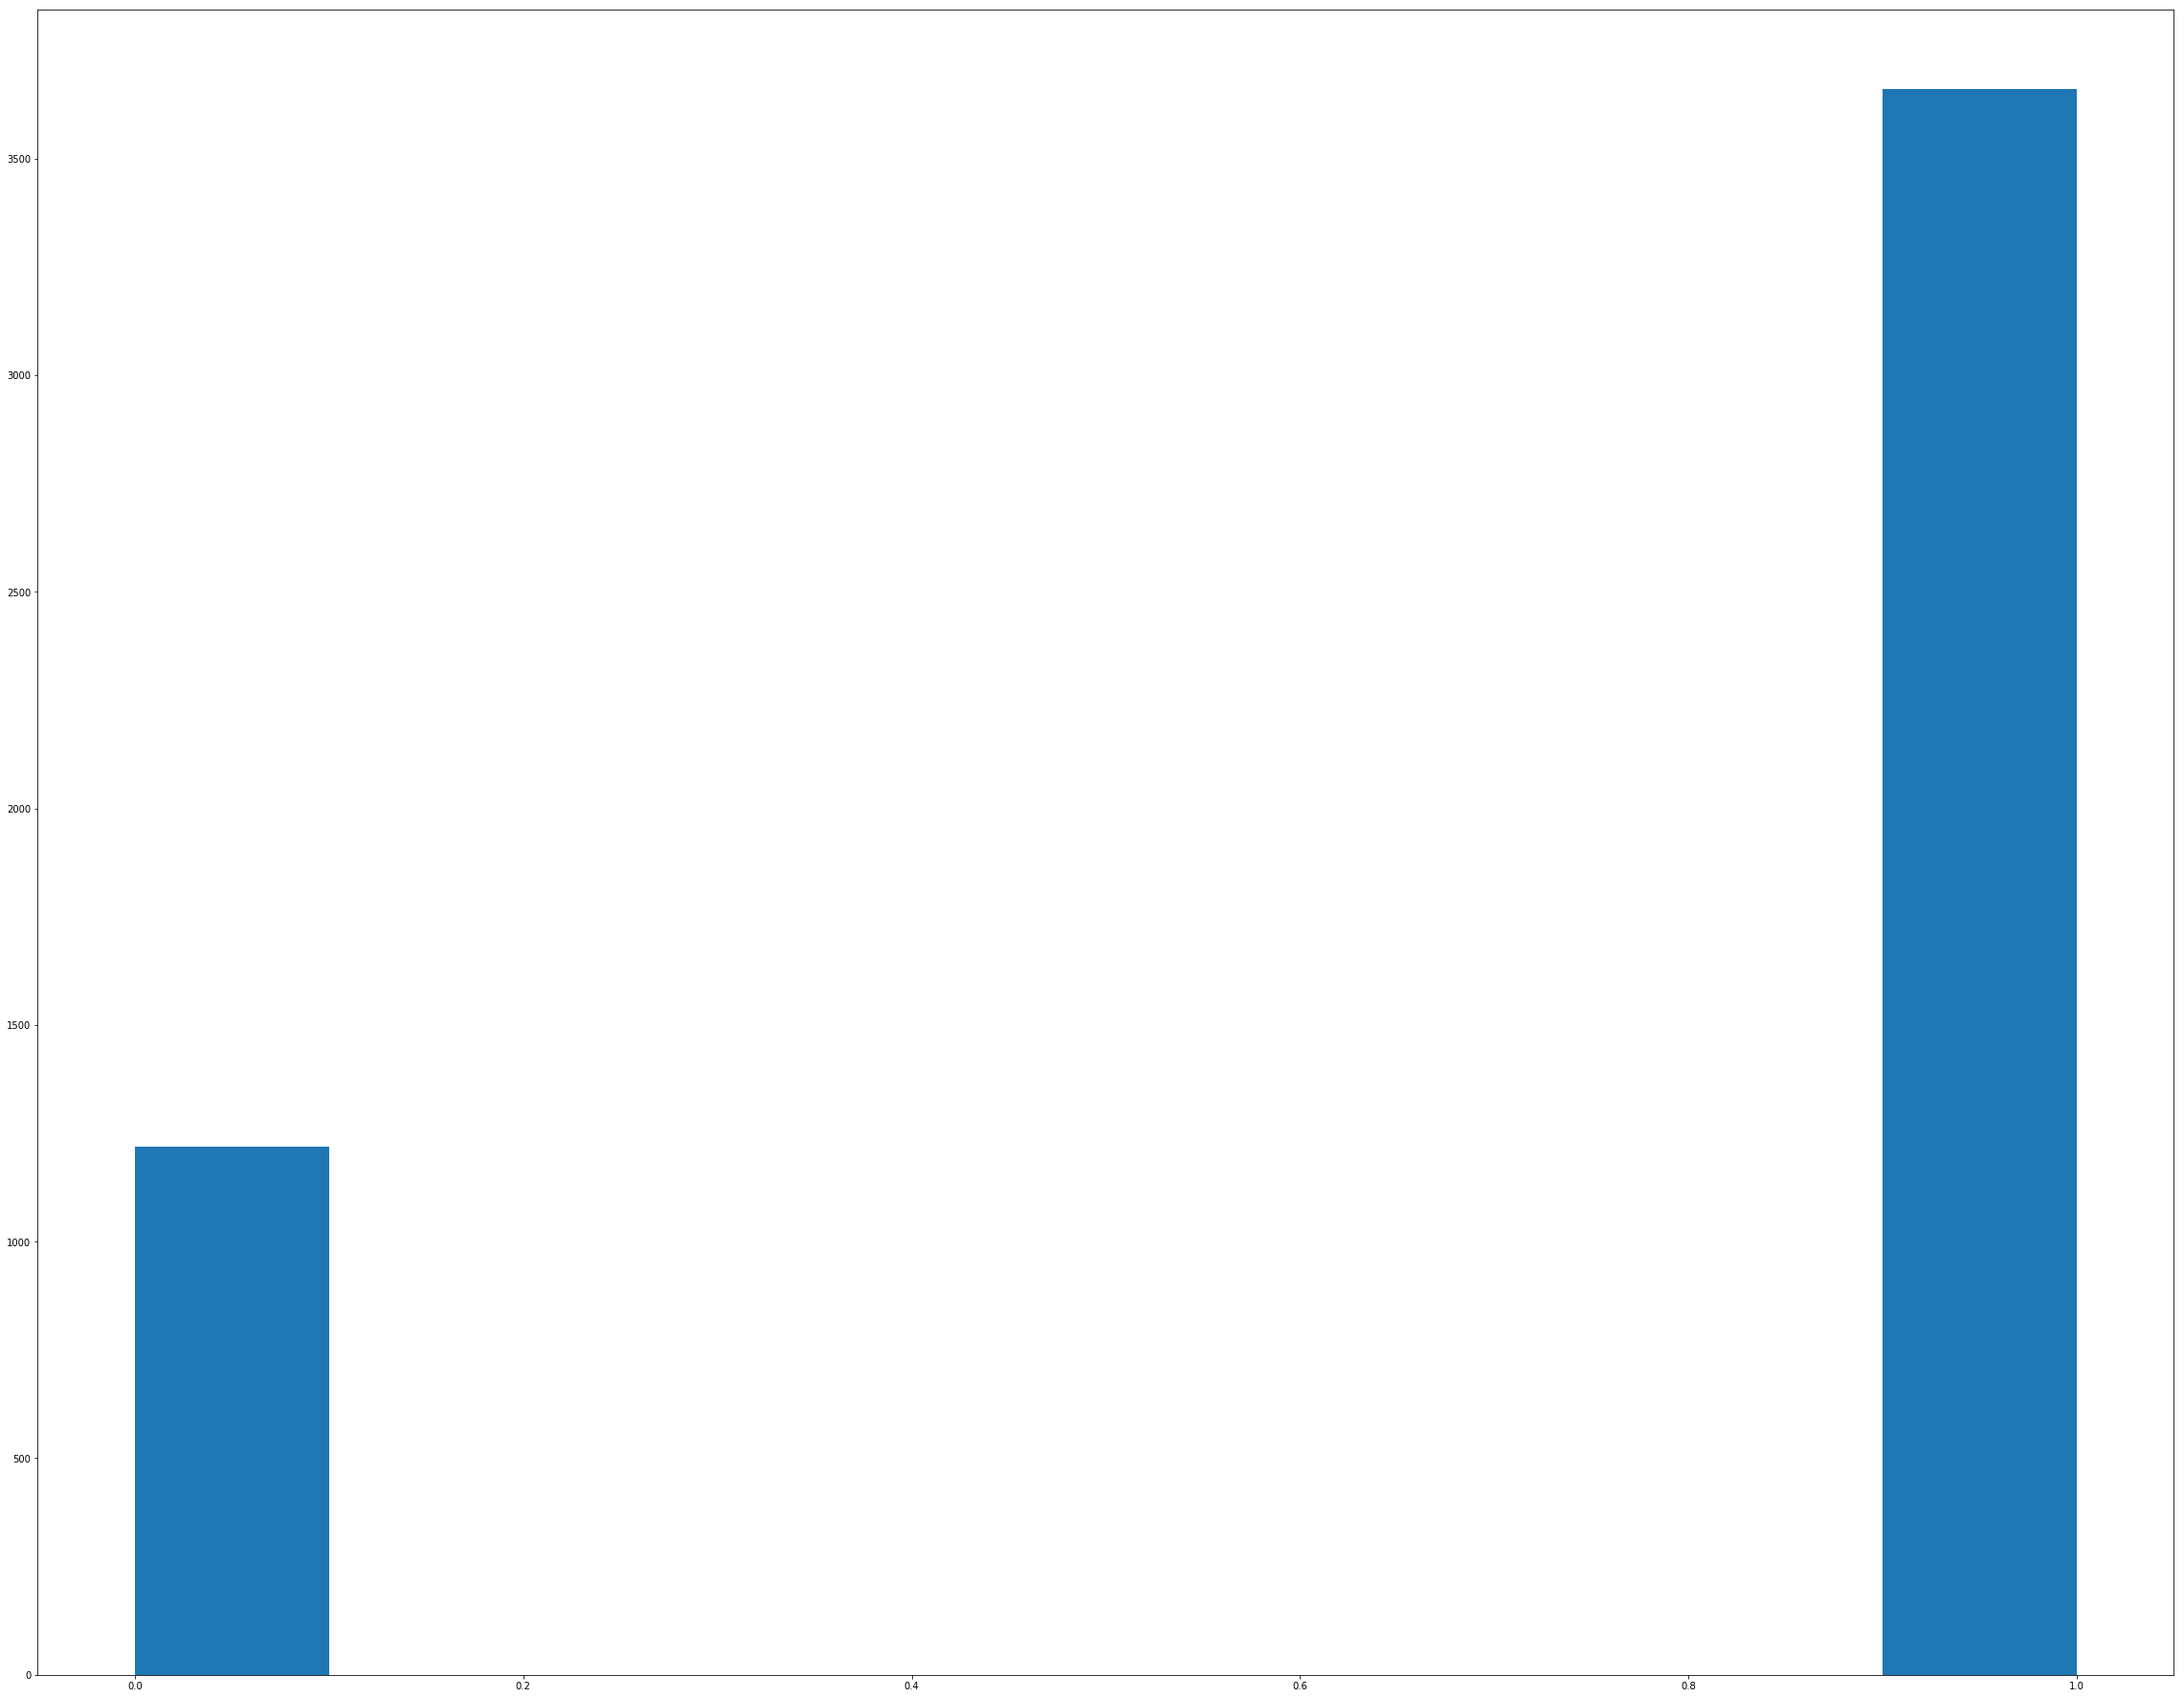

In [7]:
the_label2=lb.fit_transform(the_label)
plt.hist(the_label2)

nilai_maks=[]
for matriks in the_signal:
    nilai_maks.append(np.max(matriks))

#nilmax=np.max(nilai_maks)
#print('nilai maks',np.max(nilai_maks))
the_signal=the_signal*1.0/nilmax

In [8]:
the_labelx=lb.fit_transform(the_label)

the_labelx = keras.utils.to_categorical(the_labelx, 2)


In [9]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv1D number of filters
        kernel_size (int): Conv1D square kernel dimensions
        strides (int): Conv1D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal'
                 )

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [10]:
def resnet_v1(input_shape, depth, num_classes=2):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        #print('the stack',stack)
        for res_block in range(num_res_blocks):
            print('xxxyyy',stack,res_block)
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                
            x = keras.layers.add([x, y])
            #print('addkah')
            x = Activation('relu')(x)
        num_filters *= 2
        x=Dropout(0.25)(x)
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(10,
                    activation='relu')(y)
    #outputs = Activation('relu')(outputs)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(outputs)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Conv1D
from keras.layers.core import Dropout

from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D

keras.backend.clear_session()


# Training parameters
batch_size = 20  # orig paper trained all networks with batch_size=128

data_augmentation = True
num_classes = 2
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()


input_shape = the_signal.shape[1:]
print(input_shape)
depth=26

def call_model():
    keras.backend.clear_session()
    model = resnet_v1(input_shape=input_shape, depth=depth)
    return model

(250, 250, 1)


In [12]:
modelx=call_model()
modelx.summary()

xxxyyy 0 0
xxxyyy 0 1
xxxyyy 0 2
xxxyyy 0 3
xxxyyy 1 0
xxxyyy 1 1
xxxyyy 1 2
xxxyyy 1 3
xxxyyy 2 0
xxxyyy 2 1
xxxyyy 2 2
xxxyyy 2 3
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 250, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 250, 250, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 250, 250, 16) 0     

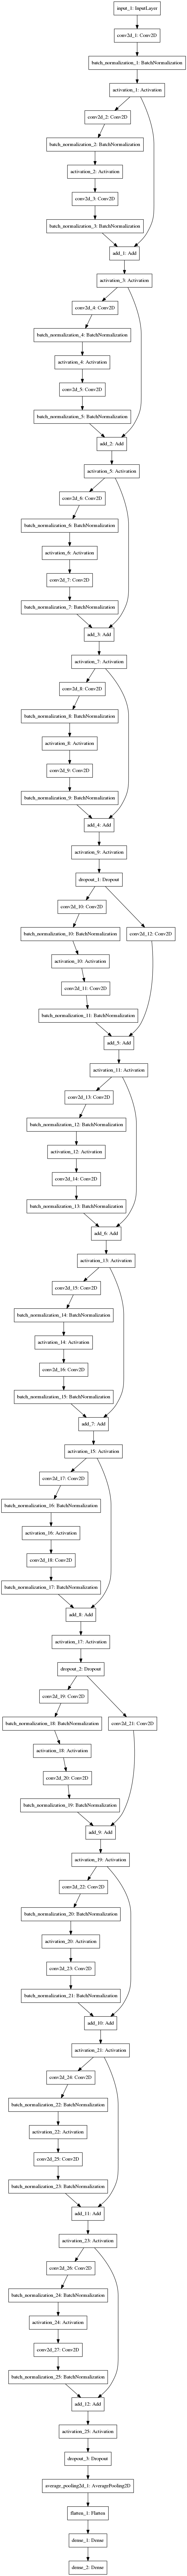

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(modelx, to_file='resnet.png')

In [14]:
unique2, counts2 = np.unique(the_labelx, return_counts=True)
print(counts2)

[4880 4880]


In [15]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.0001
EPOCHS = 100
from keras.optimizers import SGD

# compile the model using SGD as our optimizer and categorical
# cross-entropy loss (you'll want to use binary_crossentropy
# for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)
#model.compile(loss="categorical_crossentropy", optimizer="adam",           m       0.89      0.79      0.84       449

#	metrics=["accuracy"])

[INFO] training network...


In [16]:
fracx=0.66
n2=the_signal.shape[0]
n1=int(fracx*n2)

trainX=the_signal[0:n1]
trainY=the_labelx[0:n1]
    
testX=the_signal[n1:n2]
testY=the_labelx[n1:n2]

In [17]:
trainX.shape,trainY.shape

((3220, 250, 250, 1), (3220, 2))

In [18]:
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
#!rm -f /kaggle/working/breast.hdf5
#model_name_wrt='/kaggle/working/breast.hdf5'
# Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
#es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20,verbose=1, mode='auto', restore_best_weights=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)


# Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-20, mode='auto', verbose=1)
# Save the best value of the model for future use
#sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)


callbacks = [rlr]


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from datetime import datetime

modelx.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01),
        metrics=["accuracy"])
H = modelx.fit(trainX, trainY, validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=20,callbacks=callbacks)
predictions = modelx.predict(testX, batch_size=20)




Train on 3220 samples, validate on 1660 samples
Epoch 1/100
3220/3220 [==============================] - 85s 26ms/step - loss: 0.9732 - accuracy: 0.7879 - val_loss: 0.7467 - val_accuracy: 0.2843
Epoch 2/100
3220/3220 [==============================] - 71s 22ms/step - loss: 0.3976 - accuracy: 0.8540 - val_loss: 0.5714 - val_accuracy: 0.6524
Epoch 3/100
3220/3220 [==============================] - 71s 22ms/step - loss: 0.3774 - accuracy: 0.8593 - val_loss: 0.3827 - val_accuracy: 0.8693
Epoch 4/100
3220/3220 [==============================] - 71s 22ms/step - loss: 0.3782 - accuracy: 0.8627 - val_loss: 0.3685 - val_accuracy: 0.8620
Epoch 5/100
3220/3220 [==============================] - 71s 22ms/step - loss: 0.3757 - accuracy: 0.8612 - val_loss: 0.3613 - val_accuracy: 0.8705
Epoch 6/100
3220/3220 [==============================] - 71s 22ms/step - loss: 0.3703 - accuracy: 0.8568 - val_loss: 0.5467 - val_accuracy: 0.7645
Epoch 7/100
3220/3220 [==============================] - 71s 22ms/step

In [20]:
predictions = modelx.predict(testX, batch_size=20)


print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))


              precision    recall  f1-score   support

           m       0.74      0.83      0.78       409
           n       0.94      0.91      0.92      1251

    accuracy                           0.89      1660
   macro avg       0.84      0.87      0.85      1660
weighted avg       0.89      0.89      0.89      1660



In [21]:
predictions = modelx.predict(trainX, batch_size=20)

print(classification_report(trainY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))


              precision    recall  f1-score   support

           m       0.77      0.87      0.82       811
           n       0.95      0.91      0.93      2409

    accuracy                           0.90      3220
   macro avg       0.86      0.89      0.88      3220
weighted avg       0.91      0.90      0.90      3220



In [22]:
ns_probs = [0 for _ in range(len(testY))]


In [23]:
lr_probs = modelx.predict(testX)


In [24]:
lr_probs = lr_probs[:, 1]


In [25]:
testy=np.zeros(len(testY))
for i in range(len(testY)):
    testy[i]=np.argmax(testY[i])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('resnet: ROC AUC=%.3f' % (lr_auc))


No Skill: ROC AUC=0.500
resnet: ROC AUC=0.925


In [27]:
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

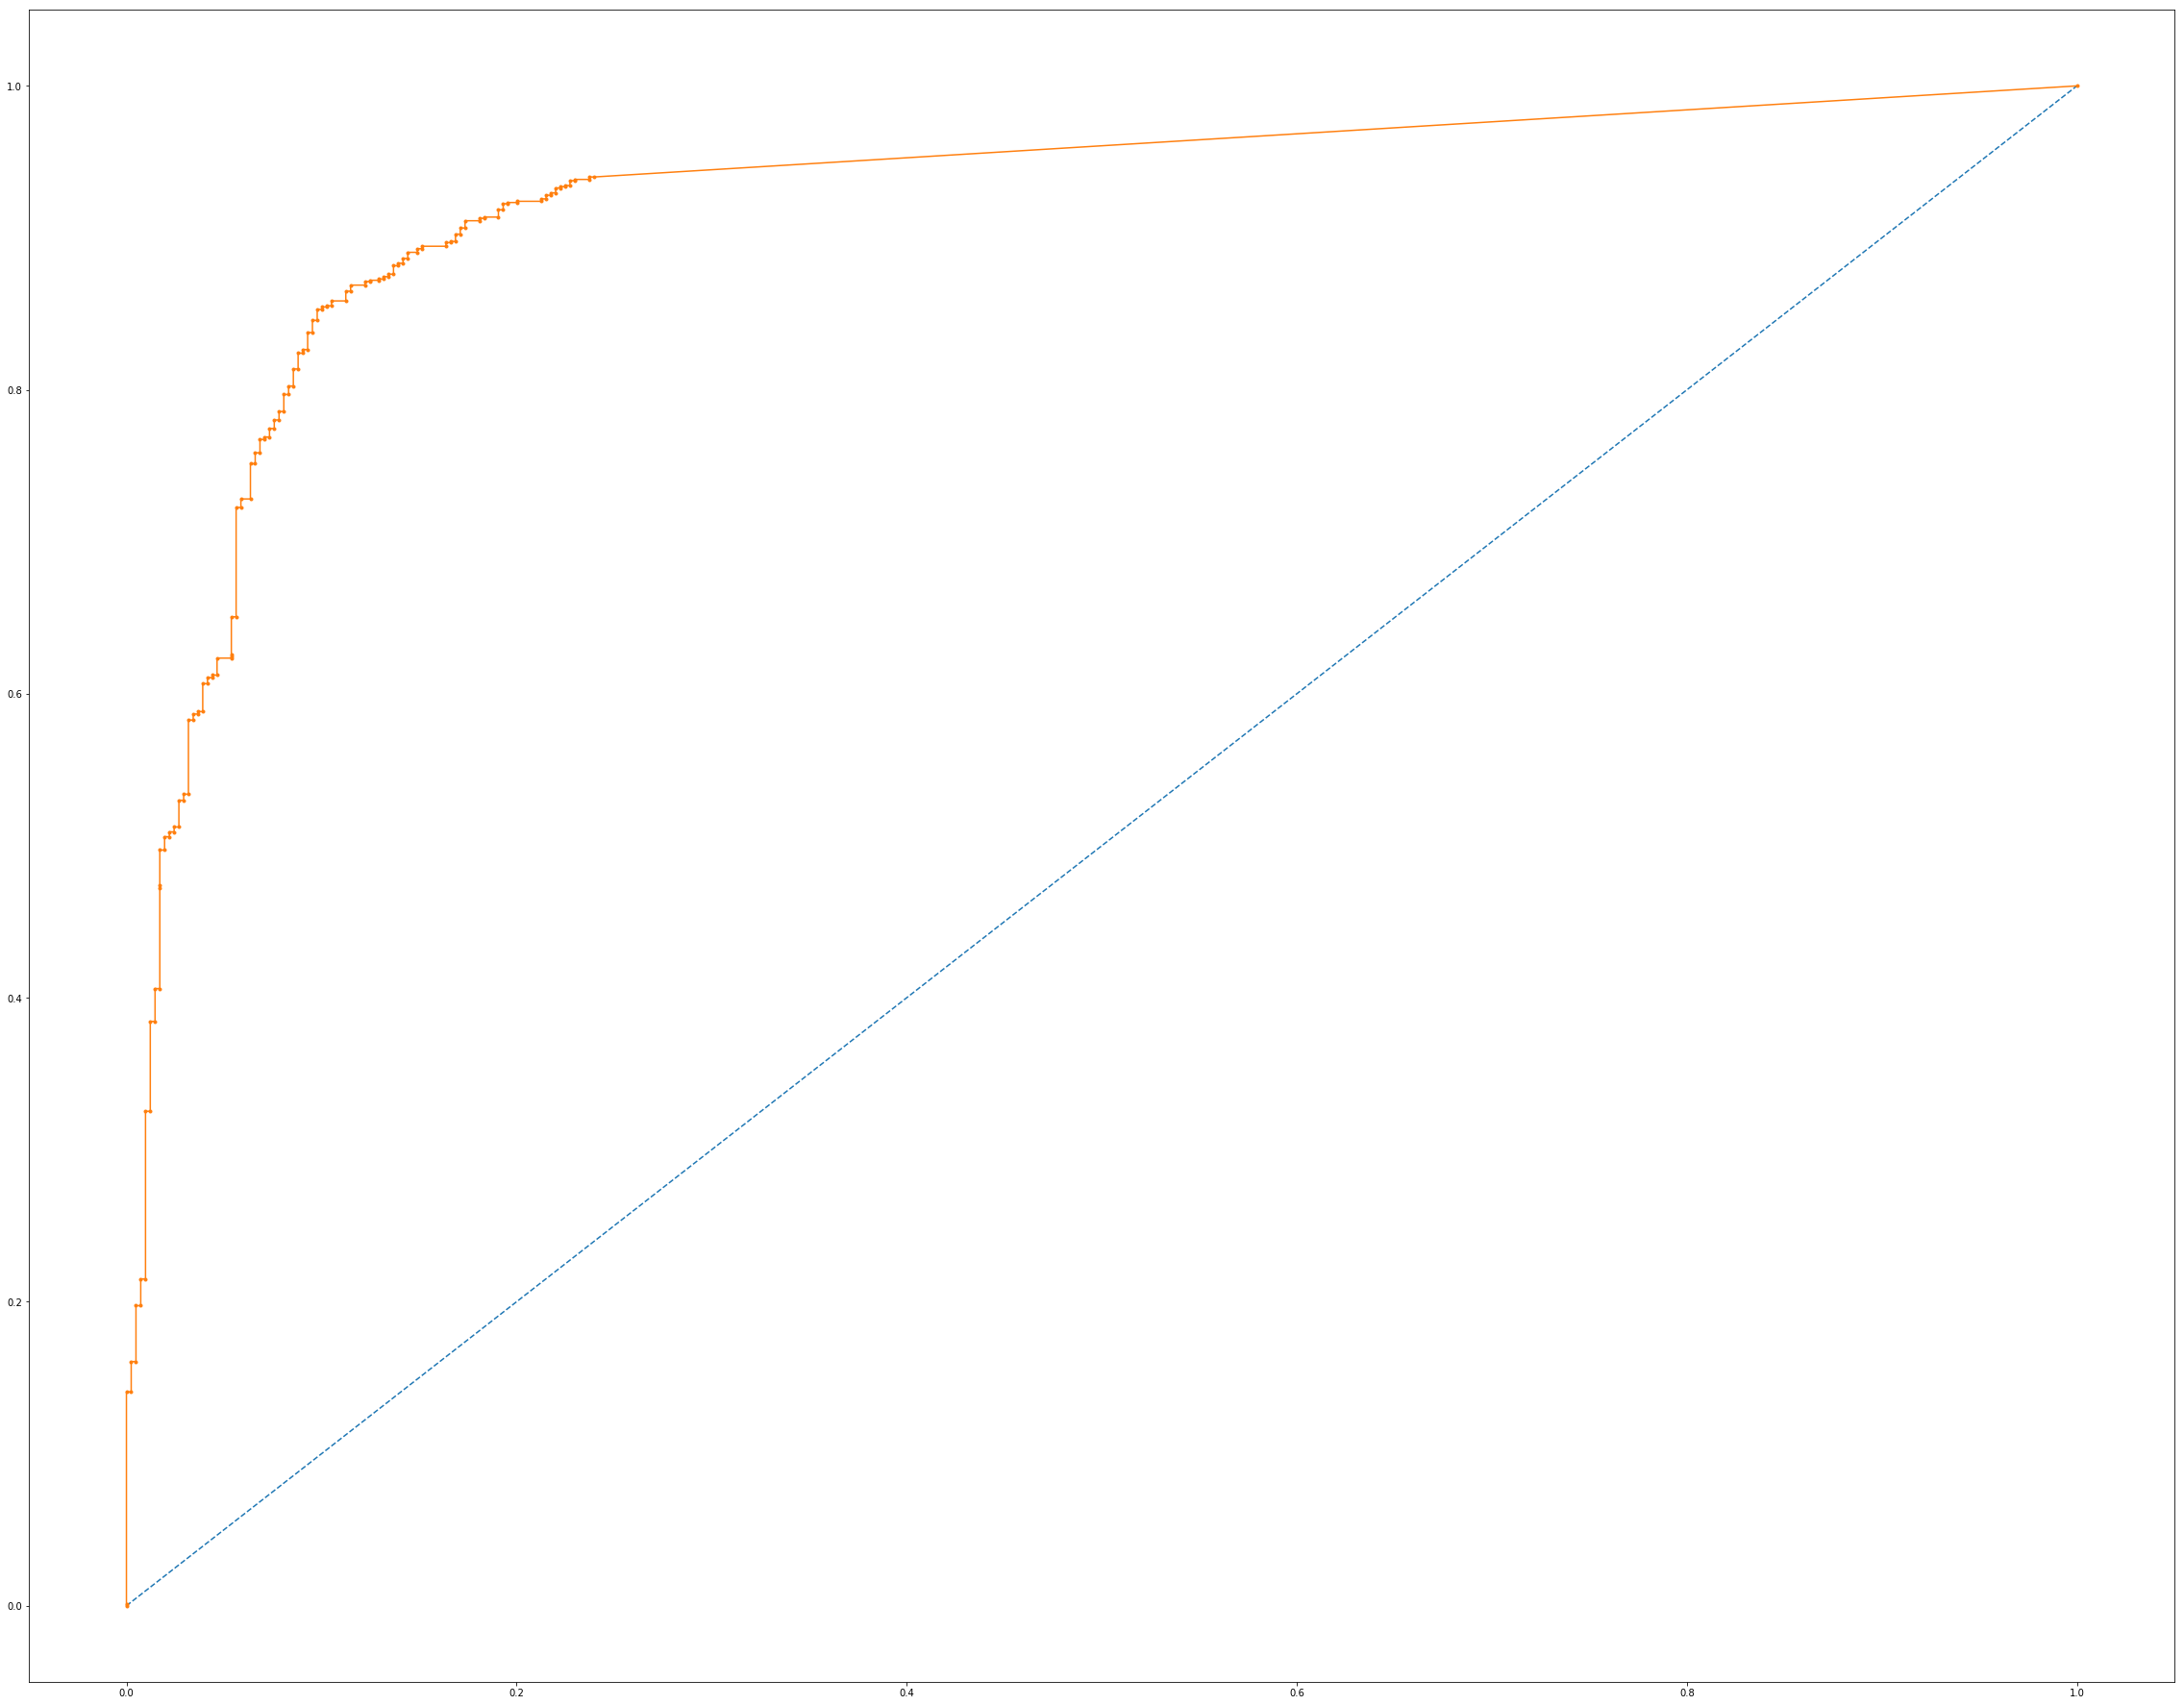

In [28]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

<Figure size 2880x2304 with 0 Axes>

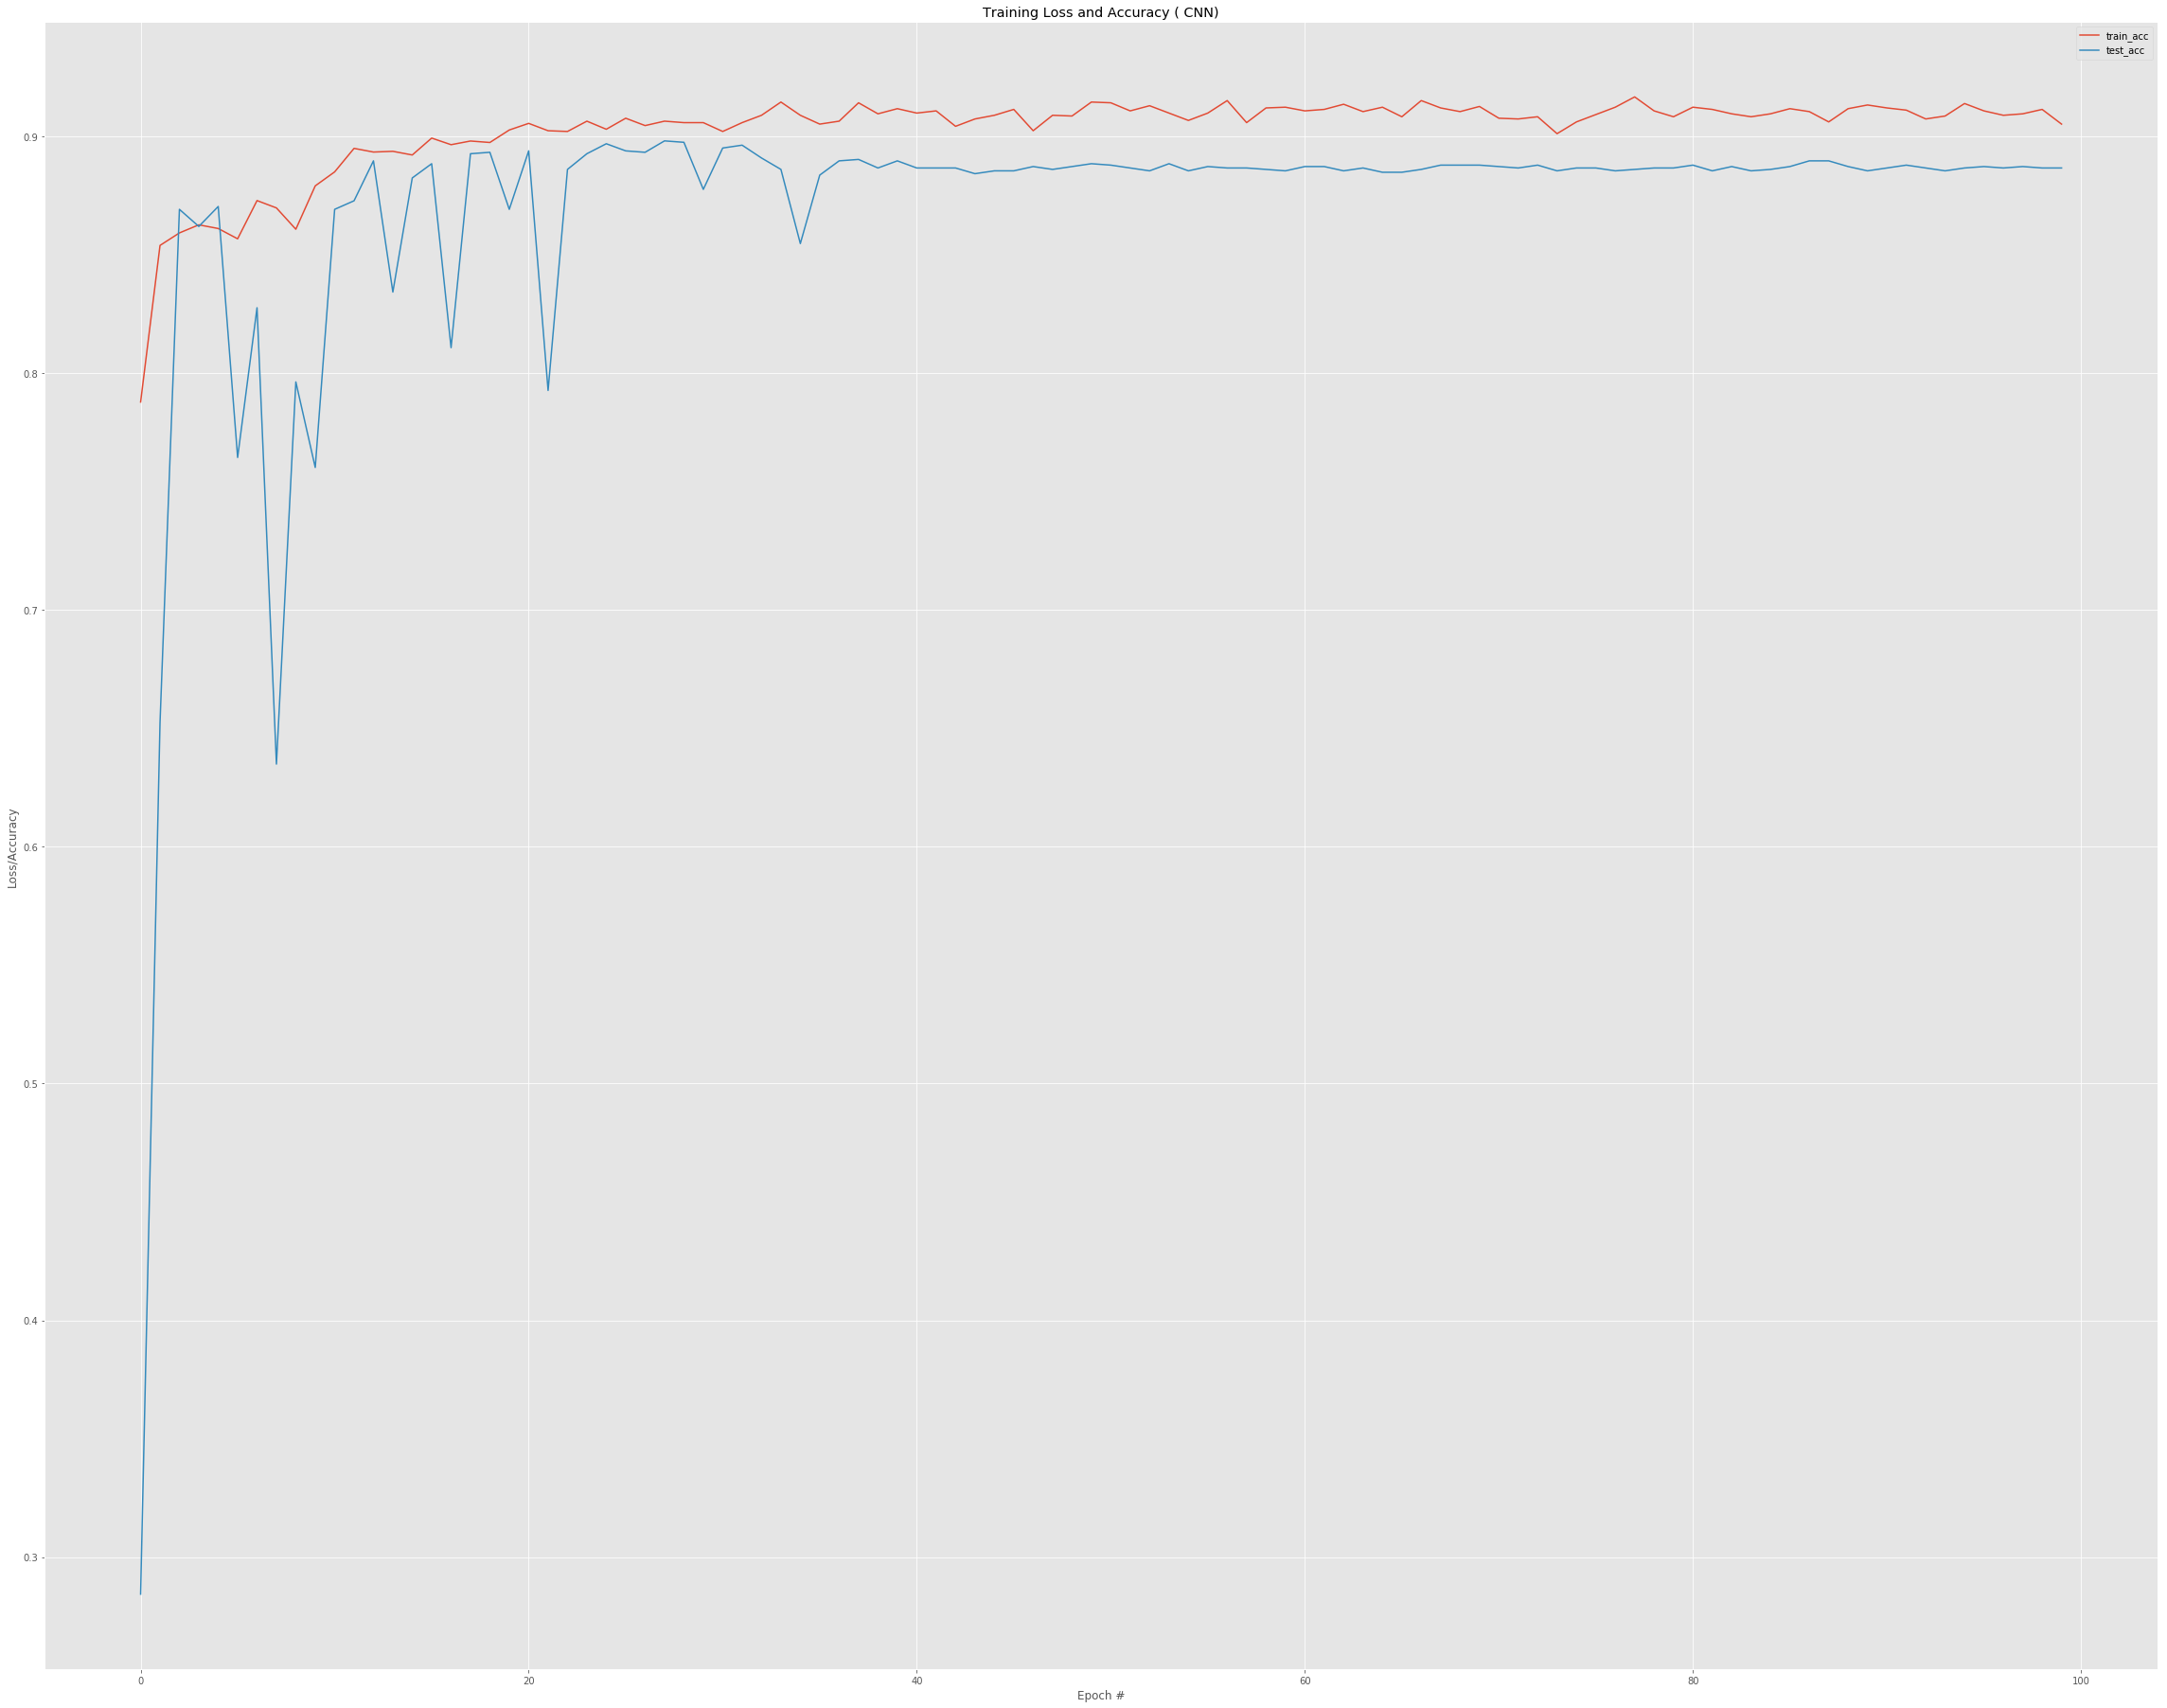

In [29]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
plt.clf()
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="test_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="test_acc")
plt.title("Training Loss and Accuracy ( CNN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('CNN.png')

In [30]:
file_loss='H_'+str(depth)+'_drop_'+'loss'
file_val_loss='H_'+str(depth)+'_drop_'+'val_loss'
file_acc='H_'+str(depth)+'_drop_'+'acc'
file_val_acc='H_'+str(depth)+'_drop_'+'val_acc'
file_testy='roc'+str(depth)+'_drop_'+'testy'
file_ns='roc'+str(depth)+'_drop_'+'ns_probs'
file_lr='roc'+str(depth)+'_drop_'+'lr_probs'





np.save(file_loss,H.history["loss"])
np.save(file_val_loss,H.history["val_loss"])
np.save(file_acc,H.history["accuracy"])
np.save(file_val_acc,H.history["val_accuracy"])

np.save(file_testy,testy)
np.save(file_ns,ns_probs)
np.save(file_lr,lr_probs)

